In [72]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [73]:

df = pd.read_csv("data.csv")

In [74]:
rt_bc = df.loc[df['rxtx'] == True]
bc_rt = df.loc[df['rxtx'] == False]

In [75]:
counts = list(bc_rt['count'])
counts = pd.Series(counts, index=pd.date_range('1-1-1959', periods=len(counts), freq='D'), name = 'value')

In [76]:
counts

1959-01-01    10
1959-01-02     5
1959-01-03    25
1959-01-04     2
1959-01-05     9
              ..
1971-12-23     5
1971-12-24    16
1971-12-25    16
1971-12-26     2
1971-12-27     2
Freq: D, Name: value, Length: 4744, dtype: int64

In [77]:
data = counts.to_frame()

In [78]:
data

value
1959-01-01     10
1959-01-02      5
1959-01-03     25
1959-01-04      2
1959-01-05      9
...           ...
1971-12-23      5
1971-12-24     16
1971-12-25     16
1971-12-26      2
1971-12-27      2

[4744 rows x 1 columns]

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

#%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

In [80]:
# Train on the first 95% and test on the last 5% of our sample
stream_sample = data
train_size = int(len(stream_sample) * 0.95)
test_size = len(stream_sample) - train_size
train, test = stream_sample.iloc[0:train_size], stream_sample.iloc[train_size:len(stream_sample)]
print(train.shape, test.shape)

(4506, 1) (238, 1)


In [81]:
# Standarize the `value` column
scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

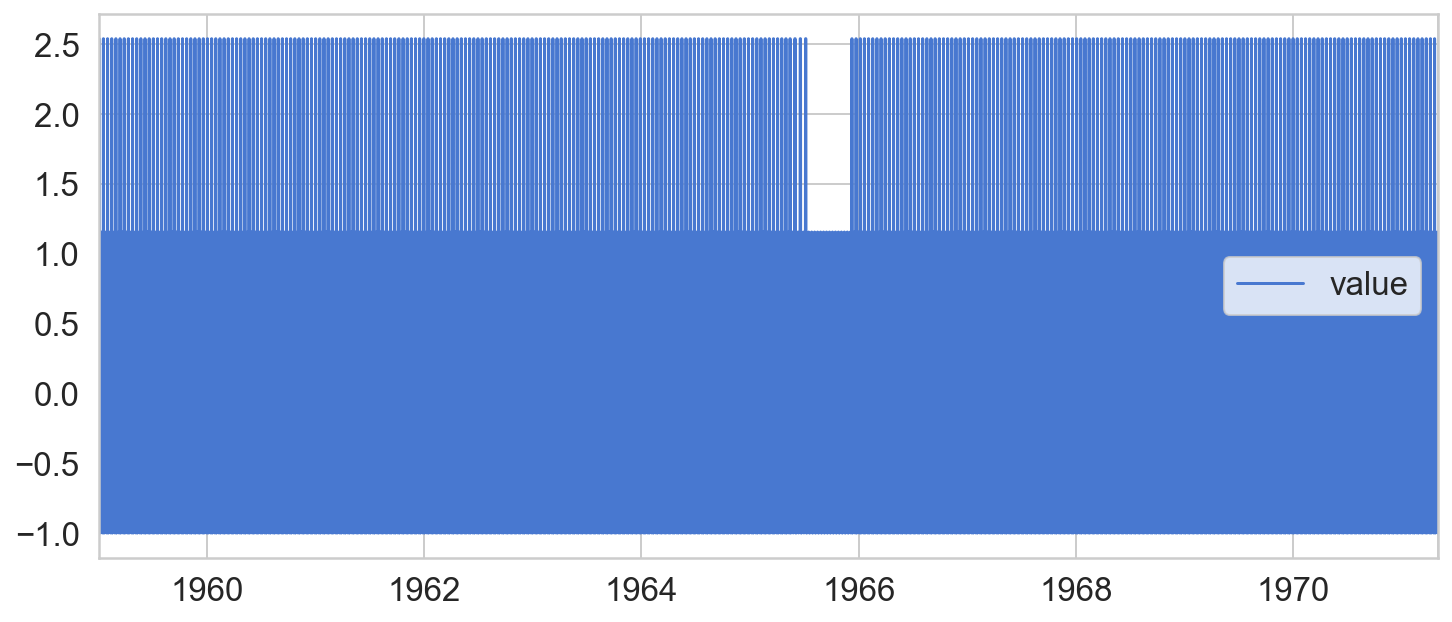

In [107]:
train.plot()

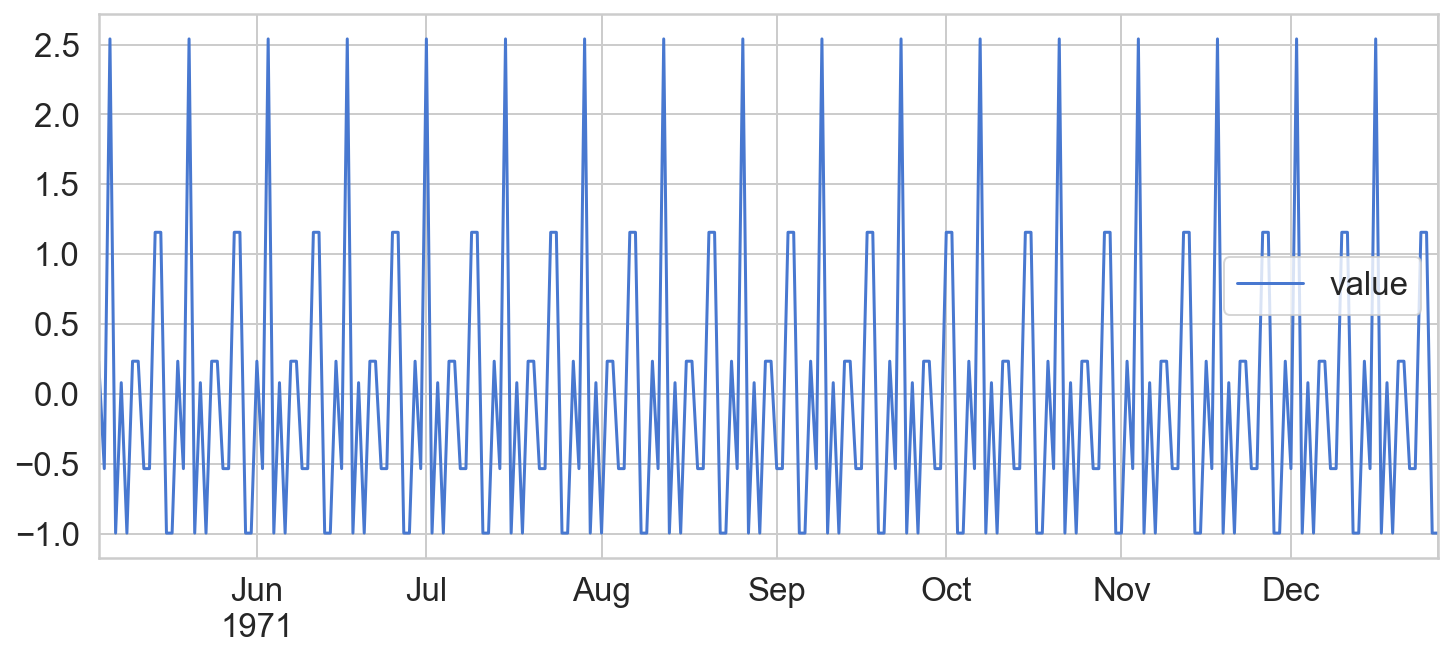

In [108]:
test.plot()

In [82]:
# Helper function to create windows of data of length `time_steps`
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [83]:
TIME_STEPS = 30

# Use the helper function to reshape the data to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
                                      train[['value']],
                                      train.value,
                                      TIME_STEPS
                                 )

X_test, y_test = create_dataset(
                                    test[['value']],
                                    test.value,
                                    TIME_STEPS
                               )

print(X_train.shape)

(4476, 30, 1)


In [84]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [85]:
print(X_test.shape)

(208, 1, 30)


In [86]:
print(X_train.shape)

(4476, 1, 30)


In [87]:
# LSTM Autoencoder Model 
def create_model(learning_rate):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=64,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(
      keras.layers.TimeDistributed(
        keras.layers.Dense(units=X_train.shape[2])
      )
    )

    optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.8)

    # Loss used in the guide is MAE. RMSE would penalize large errors more. Possible future research.
    model.compile(loss='mae', optimizer=optimizer)
    return model

In [35]:
history = []
learning_rates = [0.1 * 10**-(i/2) for i in range(8)]
for learning_rate in learning_rates:
    model = create_model(learning_rate)
    history.append(
        model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            shuffle=False,
        )
    )

Train on 4028 samples, validate on 448 samples
Epoch 1/10
4028/4028 [==============================] - 4s 935us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 2/10
4028/4028 [==============================] - 0s 92us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 3/10
4028/4028 [==============================] - 0s 89us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 4/10
4028/4028 [==============================] - 0s 91us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 5/10
4028/4028 [==============================] - 0s 89us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 6/10
4028/4028 [==============================] - 0s 89us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 7/10
4028/4028 [==============================] - 0s 93us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 8/10
4028/4028 [==============================] - 0s 89us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 9/10
4028/4028 [==============================] - 0s 90us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 1

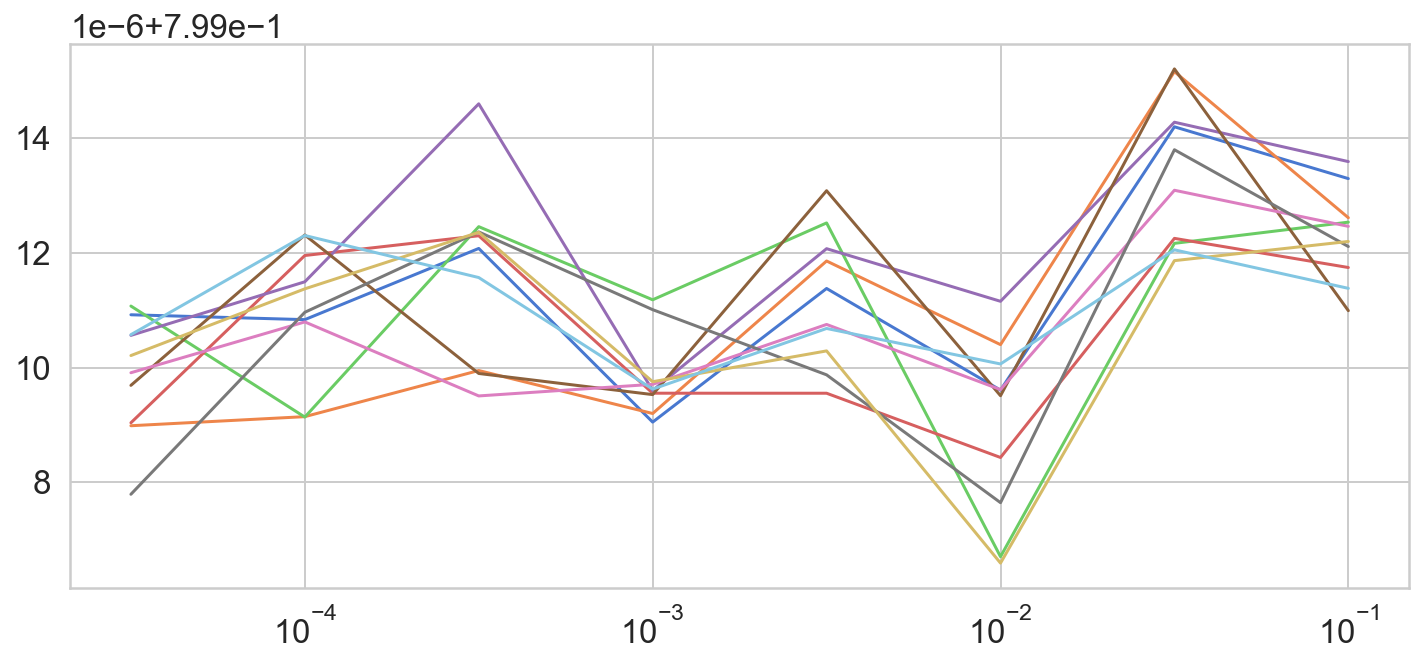

In [36]:
# Plot the learning rate vs. loss to estimate best learning rate
plt.semilogx([lr for lr in learning_rates], [trial.history['loss'] for trial in history])

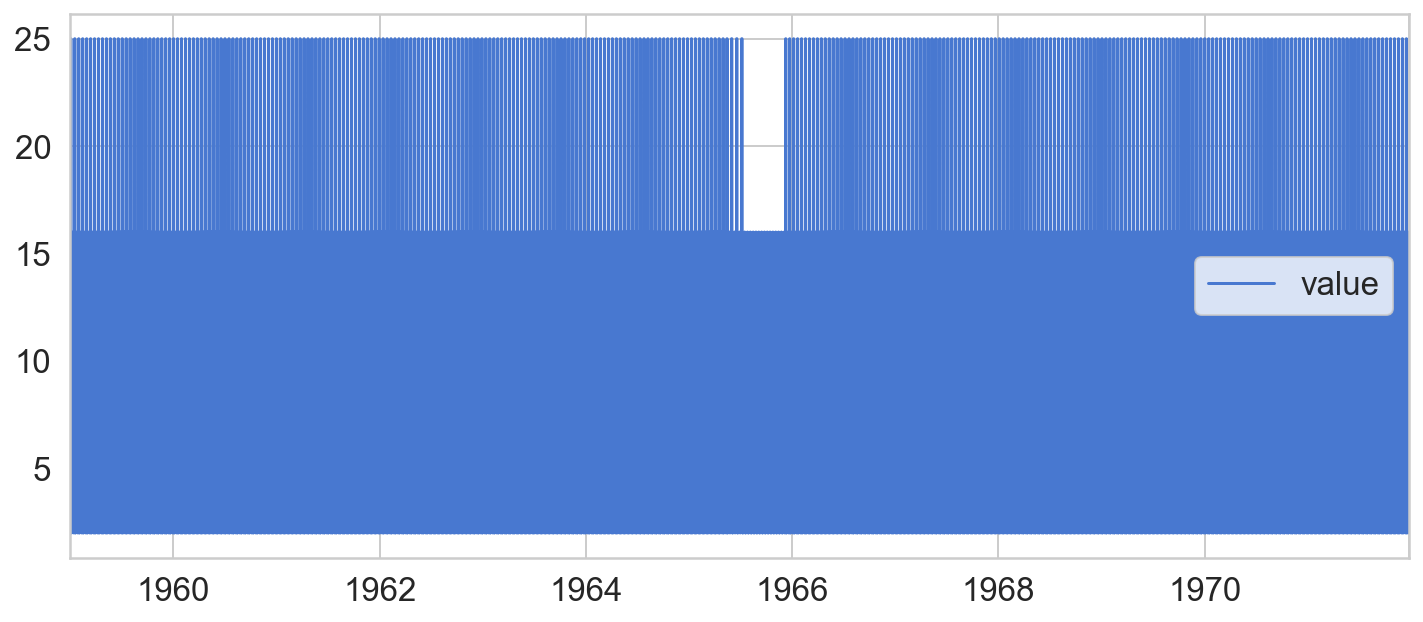

In [47]:
data.plot()

In [88]:
LEARNING_RATE = .01

In [89]:
model = create_model(LEARNING_RATE)
history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        shuffle=False,
    )


Train on 4028 samples, validate on 448 samples
Epoch 1/100
4028/4028 [==============================] - 7s 2ms/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 2/100
4028/4028 [==============================] - 0s 113us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 3/100
4028/4028 [==============================] - 0s 116us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 4/100
4028/4028 [==============================] - 0s 116us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 5/100
4028/4028 [==============================] - 0s 110us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 6/100
4028/4028 [==============================] - 0s 95us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 7/100
4028/4028 [==============================] - 0s 104us/sample - loss: 0.7990 - val_loss: 0.8017
Epoch 8/100
4028/4028 [==============================] - 0s 96us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 9/100
4028/4028 [==============================] - 0s 98us/sample - loss: 0.7990 - val_loss: 0.

Epoch 77/100
4028/4028 [==============================] - 0s 95us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 78/100
4028/4028 [==============================] - 0s 95us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 79/100
4028/4028 [==============================] - 0s 97us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 80/100
4028/4028 [==============================] - 0s 93us/sample - loss: 0.7990 - val_loss: 0.8017
Epoch 81/100
4028/4028 [==============================] - 0s 97us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 82/100
4028/4028 [==============================] - 0s 93us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 83/100
4028/4028 [==============================] - 0s 96us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 84/100
4028/4028 [==============================] - 0s 97us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 85/100
4028/4028 [==============================] - 0s 96us/sample - loss: 0.7990 - val_loss: 0.8018
Epoch 86/100
4028/4028 [=============

In [92]:
# Save/Load Model to/from Disk

model_json = model.to_json()
with open("model.02.json", "w") as json_file:
    json_file.write(model_json)
# Serialize network weights to HDF5
model.save_weights("model.02.h5")
print("Saved model to disk")

# Saved model to disk
with open("model.02.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = keras.models.model_from_json(loaded_model_json)


# load weights into new model
loaded_model.load_weights("model.02.h5")
print("Loaded model from disk")
#Loaded model from disk
print(f"Saved model matches trained model: {model.get_config() == loaded_model.get_config()}")
#Saved model matches trained model: True

Saved model to disk
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loaded model from disk
Saved model matches trained model: True


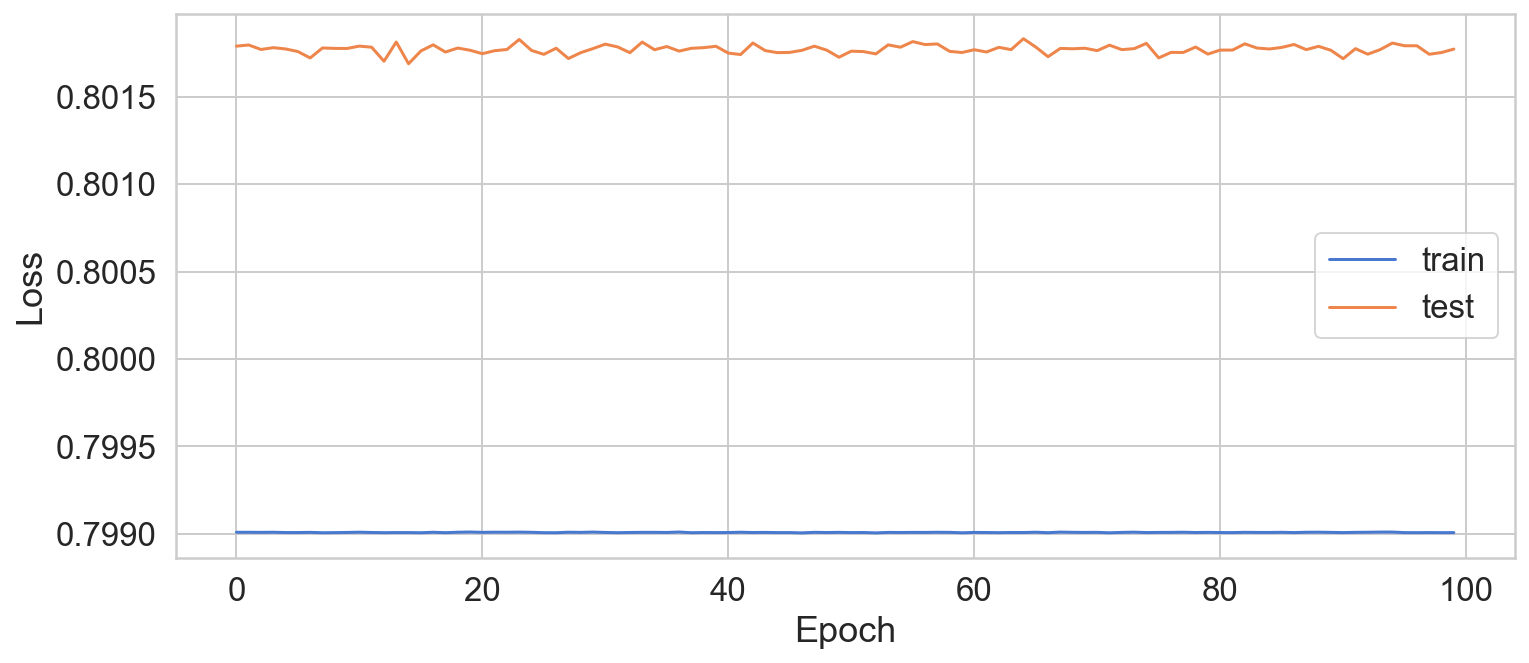

In [93]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

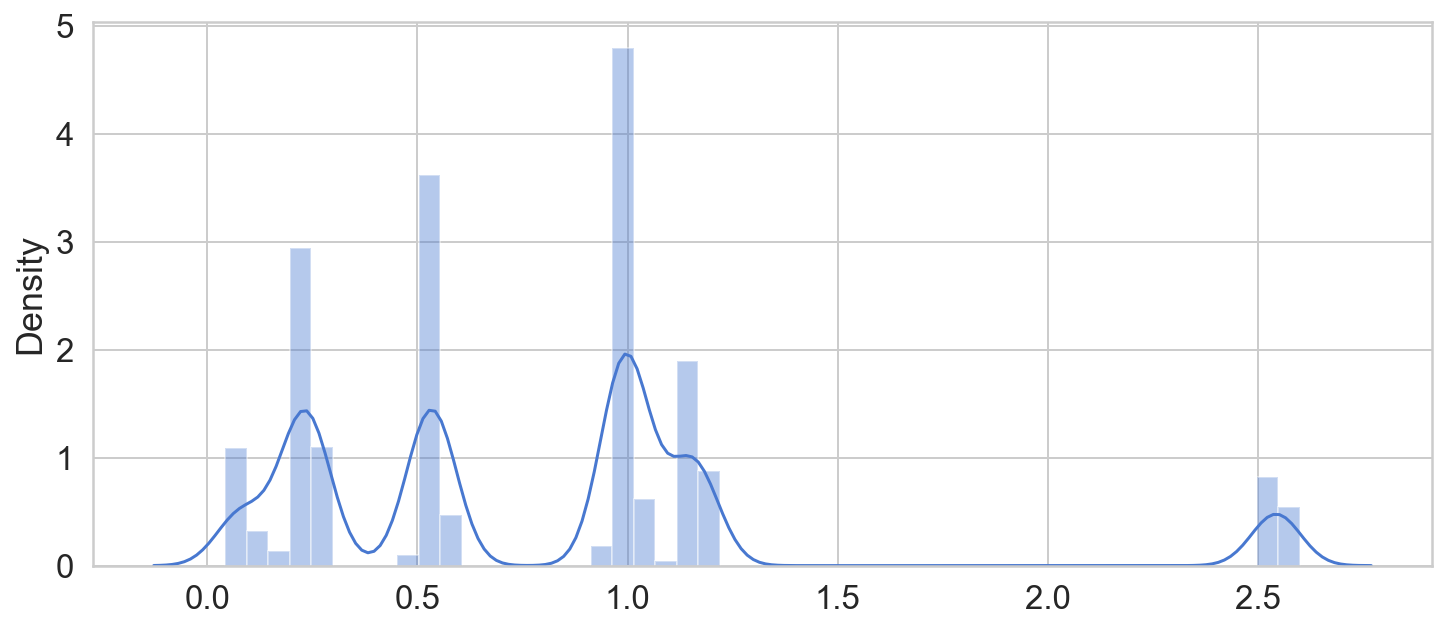

In [94]:
# Prediction

X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
sns.distplot(train_mae_loss, bins=50, kde=True);

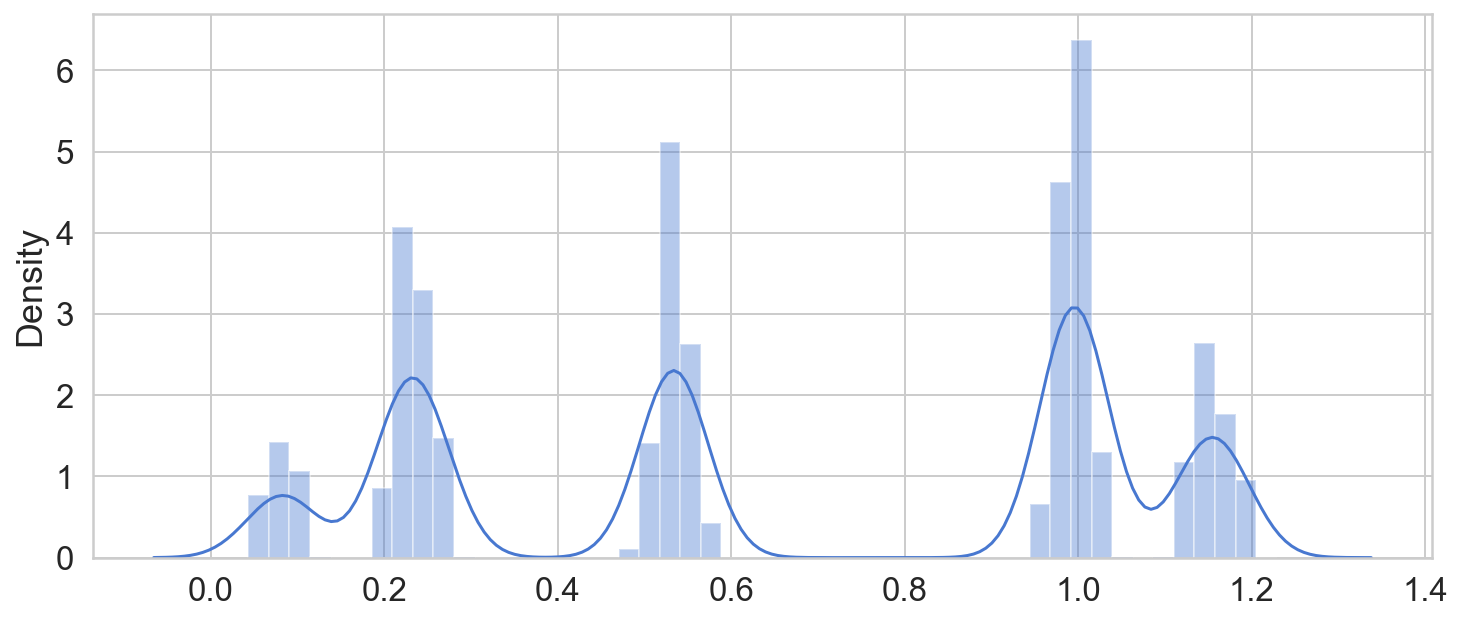

In [95]:
# Zoom
sns.distplot(train_mae_loss[train_mae_loss < 1.5], bins=50, kde=True);

In [96]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [97]:
test_mae_loss.shape

(208, 30)

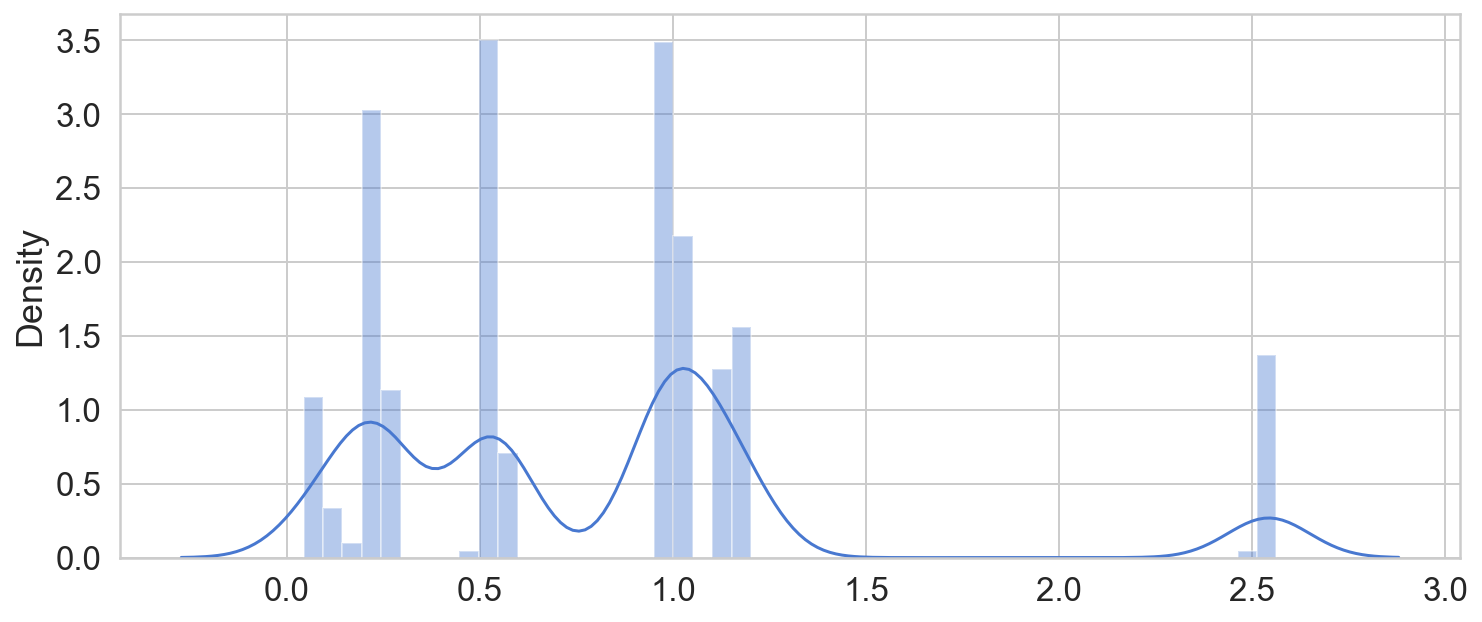

In [98]:
sns.distplot(test_mae_loss, bins=50, kde=True)

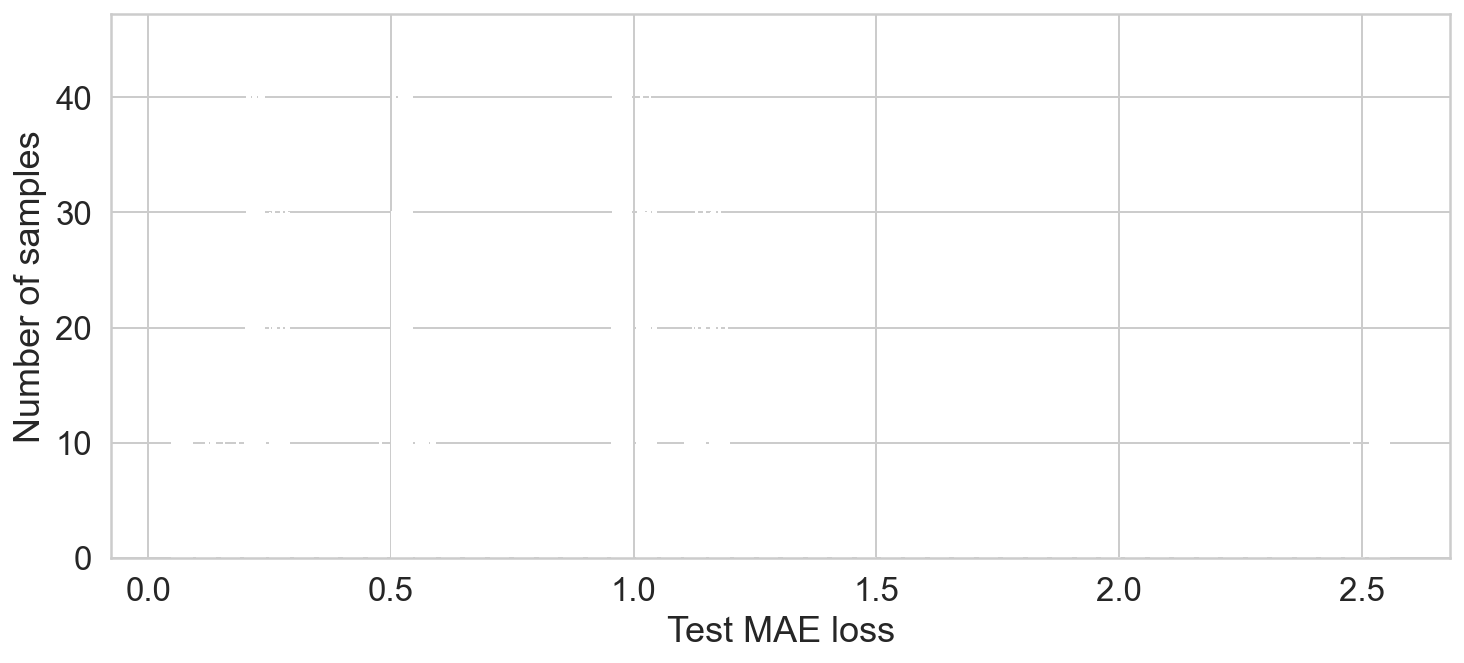

In [100]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [101]:
THRESHOLD = .5

In [102]:
test_score_df

loss  threshold  \
1971-06-03  [0.226992948642818, 0.5426393553719069, 2.5416...        0.5   
1971-06-04  [0.5125230915948893, 2.5261022257405865, 0.990...        0.5   
1971-06-05  [2.523139771518444, 0.9754396092747072, 0.0695...        0.5   
1971-06-06  [1.0006640094932835, 0.09251513474291105, 1.02...        0.5   
1971-06-07  [0.0988345830947711, 0.9982743461285452, 0.227...        0.5   
...                                                       ...        ...   
1971-12-23  [0.20585741494864013, 0.5150971684709336, 0.54...        0.5   
1971-12-24  [0.5225217372283484, 0.548131466108575, 1.1646...        0.5   
1971-12-25  [0.5504904959455277, 1.1581078811477772, 1.146...        0.5   
1971-12-26  [1.17381955153997, 1.130996749100638, 1.002340...        0.5   
1971-12-27  [1.1514305563805527, 1.006015409961782, 0.9899...        0.5   

               value  
1971-06-03  2.540210  
1971-06-04 -0.996503  
1971-06-05  0.079888  
1971-06-06 -0.996503  
1971-06-07  0.233658  
...              ...  
1971-12-23 -0.535192  
1971-12-24  1.156279  
1971-12-25  1.156279  
1971-12-26 -0.996503  
1971-12-27 -0.996503  

[208 rows x 3 columns]

In [103]:
typetest_mae_loss

NameError: name 'typetest_mae_loss' is not defined

In [104]:
test_score_df 

loss  threshold  \
1971-06-03  [0.226992948642818, 0.5426393553719069, 2.5416...        0.5   
1971-06-04  [0.5125230915948893, 2.5261022257405865, 0.990...        0.5   
1971-06-05  [2.523139771518444, 0.9754396092747072, 0.0695...        0.5   
1971-06-06  [1.0006640094932835, 0.09251513474291105, 1.02...        0.5   
1971-06-07  [0.0988345830947711, 0.9982743461285452, 0.227...        0.5   
...                                                       ...        ...   
1971-12-23  [0.20585741494864013, 0.5150971684709336, 0.54...        0.5   
1971-12-24  [0.5225217372283484, 0.548131466108575, 1.1646...        0.5   
1971-12-25  [0.5504904959455277, 1.1581078811477772, 1.146...        0.5   
1971-12-26  [1.17381955153997, 1.130996749100638, 1.002340...        0.5   
1971-12-27  [1.1514305563805527, 1.006015409961782, 0.9899...        0.5   

               value  
1971-06-03  2.540210  
1971-06-04 -0.996503  
1971-06-05  0.079888  
1971-06-06 -0.996503  
1971-06-07  0.233658  
...              ...  
1971-12-23 -0.535192  
1971-12-24  1.156279  
1971-12-25  1.156279  
1971-12-26 -0.996503  
1971-12-27 -0.996503  

[208 rows x 3 columns]

In [106]:
list(test_mae_loss)

[array([0.22724875, 0.51357536, 2.53827128, 1.00161078, 0.07191931,
        1.01635829, 0.23646814, 0.22837923, 0.52509949, 0.51455354,
        1.13002715, 1.14698328, 1.00975446, 0.99404002, 0.23698045,
        0.56632628, 2.54920132, 1.01996824, 0.06381382, 0.98823922,
        0.26573005, 0.22255871, 0.54003747, 0.52110289, 1.12178744,
        1.15494554, 1.01873213, 0.99631466, 0.24401426, 0.51840131]),
 array([0.53266626, 2.53841037, 0.98523017, 0.06438698, 0.95605262,
        0.27124802, 0.23335299, 0.5455078 , 0.57541921, 1.14549799,
        1.18704553, 0.96589889, 0.96911809, 0.22538441, 0.53589302,
        2.54007809, 1.02530416, 0.1010126 , 1.01034817, 0.21636991,
        0.19966213, 0.52078357, 0.51868975, 1.13628231, 1.19910881,
        1.01069428, 0.96162043, 0.23481467, 0.56028639, 2.54851851]),
 array([2.54833473, 0.99470506, 0.09318605, 0.98096451, 0.18724834,
        0.2602794 , 0.55458421, 0.5549743 , 1.15348407, 1.15239742,
        1.01061734, 1.01053349, 0.22349932, 

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]

plt.plot(
    test.value.iloc[TIME_STEPS:].index, 
    scaler.inverse_transform(test.iloc[TIME_STEPS:].value),
    alpha=0.6
)

sns.scatterplot(
    anomalies.index,
    scaler.inverse_transform(anomalies.value),
    color=sns.color_palette()[3],
    s=52,
    label='anomaly'
)
plt.xticks(rotation=25)
plt.legend()
print(f'Number of anomalies detected: {len(anomalies)}')
print(f'Percent of timestamps labelled anomalies: {len(anomalies)/len(test_score_df) * 100:.1f}%')

ValueError: setting an array element with a sequence.

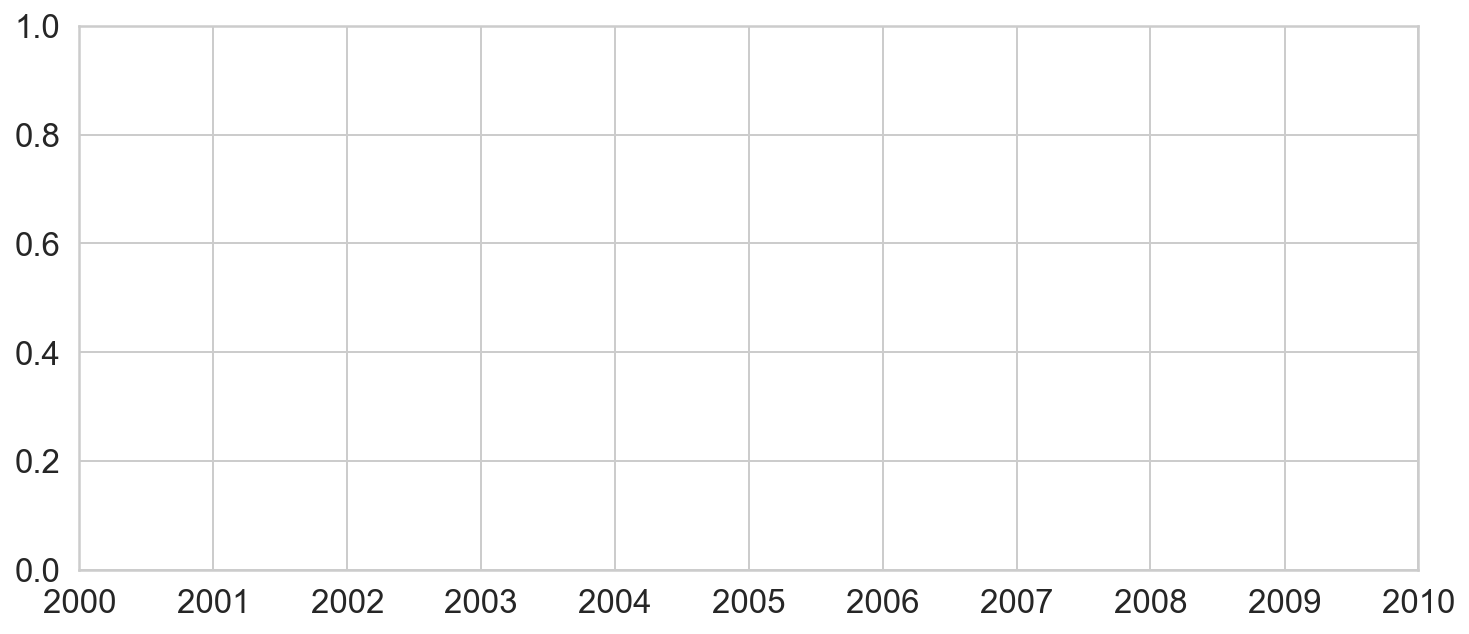

In [105]:
test_score_df = pd.DataFrame(index=test.iloc[TIME_STEPS:].index)
test_score_df['loss'] = list(test_mae_loss)
test_score_df['threshold'] = THRESHOLD
#test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
# test_score_df['anomaly'] = test_score_df.loss < test_score_df.threshold
test_score_df['value'] = test.iloc[TIME_STEPS:].value

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()
plt.show()